<a href="https://colab.research.google.com/github/pscabral/IFMA_Softex/blob/main/InceptionV3.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
from keras.applications.inception_v3 import  , preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# Especificar os caminhos para os diretórios que contêm as imagens de treinamento, validação e teste
diretorio_treinamento = '/content/fruits_v2/train'
diretorio_validacao = '/content/fruits_v2/val'
diretorio_teste = '/content/fruits_v2/test'

# Função para carregar imagens de um diretório específico
def carregar_imagens(diretorio):
    imagens = []
    rotulos = []

    for classe in os.listdir(diretorio):
        classe_dir = os.path.join(diretorio, classe)
        for imagem_nome in os.listdir(classe_dir):
            caminho_imagem = os.path.join(classe_dir, imagem_nome)

            img = Image.open(caminho_imagem)
            img = img.resize((299, 299))
            img = np.array(img)
            img = preprocess_input(img)

            imagens.append(img)
            rotulos.append(classe)

    return np.array(imagens), np.array(rotulos)

# Crie geradores de dados para treinamento, validação e teste
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = datagen_train.flow_from_directory(
    directory=diretorio_treinamento,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

datagen_validation = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = datagen_validation.flow_from_directory(
    directory=diretorio_validacao,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

# Carregar o modelo InceptionV3 pré-treinado com pesos do ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

model.fit(train_generator, epochs=1, validation_data=validation_generator, callbacks=[early_stopping, model_checkpoint])

# Verificar imagens no diretório de teste
def fazer_previsao(caminho_imagem, model):
    if os.path.isfile(caminho_imagem):
        img = Image.open(caminho_imagem)
        img = img.resize((299, 299))
        img = np.array(img)
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)

        previsao = model.predict(img)
        classe_predita = np.argmax(previsao)

        return classe_predita
    else:
        return None

for classe in os.listdir(diretorio_teste):
    classe_dir = os.path.join(diretorio_teste, classe)
    for imagem_nome in os.listdir(classe_dir):
        caminho_imagem = os.path.join(classe_dir, imagem_nome)

        classe_predita = fazer_previsao(caminho_imagem, model)

        if classe_predita is not None:
            print(f'Imagem: {imagem_nome}, Classe Preditada: {classe_predita}')

# Avaliar o modelo no conjunto de teste
teste_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = teste_datagen.flow_from_directory(
    directory=diretorio_teste,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

accuracy = model.evaluate(test_generator)[1]
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')

In [4]:
class_indices = train_generator.class_indices
print(class_indices)

{'Apple Braeburn': 0, 'Apple Granny Smith': 1, 'Apricot': 2, 'Avocado': 3, 'Banana': 4, 'Blueberry': 5, 'Cactus fruit': 6, 'Cantaloupe': 7, 'Cherry': 8, 'Clementine': 9, 'Corn': 10, 'Cucumber Ripe': 11, 'Grape Blue': 12, 'Kiwi': 13, 'Lemon': 14, 'Limes': 15, 'Mango': 16, 'Onion White': 17, 'Orange': 18, 'Papaya': 19, 'Passion Fruit': 20, 'Peach': 21, 'Pear': 22, 'Pepper Green': 23, 'Pepper Red': 24, 'Pineapple': 25, 'Plum': 26, 'Pomegranate': 27, 'Potato Red': 28, 'Raspberry': 29, 'Strawberry': 30, 'Tomato': 31, 'Watermelon': 32}


1/1 [==============================] - 2s 2s/step


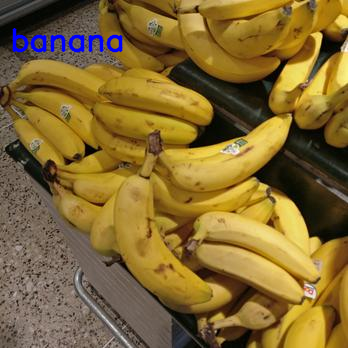

In [64]:
#!pip install gTTS
import cv2
import numpy as np
from keras.applications.vgg19 import preprocess_input, VGG19, decode_predictions
from google.colab.patches import cv2_imshow
from gtts import gTTS
import IPython.display as ipd

# Caminho para a imagem de teste
caminho_imagem_teste = '/content/Testes/Banana_001.jpg'  # Substitua pelo caminho da sua imagem de teste

# Ler a imagem de teste
image = cv2.imread(caminho_imagem_teste)

# Redimensionar a imagem para o tamanho esperado pela VGG19
image_resized = cv2.resize(image, (224, 224))

# Adicionar a dimensão do lote (batch)
image_resized = np.expand_dims(image_resized, axis=0)

# Pré-processamento específico da VGG19
image_preprocessed = preprocess_input(image_resized)

# Carregar o modelo VGG19 pré-treinado
model = VGG19(weights='imagenet')

# Fazer a previsão usando o modelo treinado
predicted_label = model.predict(image_preprocessed)

# Descodificar o rótulo previsto para obter a classe
predicted_class = decode_predictions(predicted_label, top=1)[0][0][1]

# Exibir a imagem com a previsão
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(image, f'{predicted_class}', (10, 50), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
cv2_imshow(image)

# Gerar o arquivo de áudio com o nome do produto previsto
tts = gTTS(text=f'O produto é {predicted_class}', lang='pt')
tts.save('/content/prevision.mp3')

# Reproduzir o arquivo de áudio
ipd.Audio('/content/prevision.mp3')

<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step


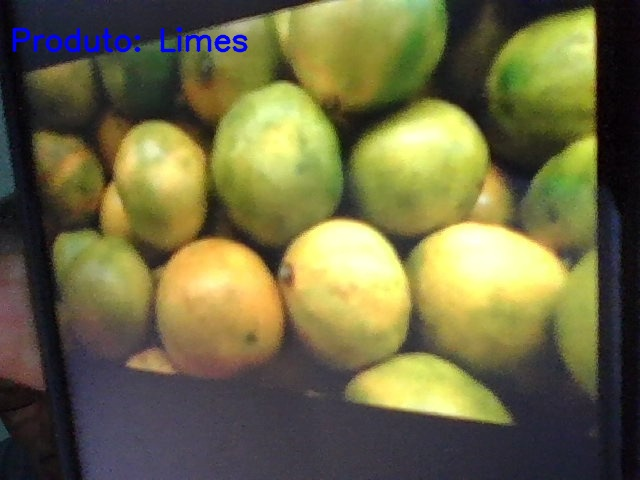

In [63]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

# Carregar o modelo treinado
model = load_model('/content/best_model.h5')

# Lista de nomes de produtos correspondente às classes previstas pelo modelo
product_names = [
    'Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana',
    'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine',
    'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes',
    'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit',
    'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple',
    'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon'
]

# Função para obter o nome do produto previsto
def get_predicted_product(predicted_label):
    # Adicione sua lógica para mapear a saída do modelo para o nome do produto
    # Aqui, estamos assumindo que predicted_label é um vetor de probabilidade e estamos obtendo a classe com maior probabilidade
    class_index = np.argmax(predicted_label)
    predicted_product = product_names[class_index]
    return predicted_product

def capture_and_classify():
    js = Javascript('''
    async function captureImage() {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture Image';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({ video: true });

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture Image to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('captureImage()')
    binary = b64decode(data.split(',')[1])

    # Salvar a imagem temporariamente
    with open('temp.jpg', 'wb') as f:
        f.write(binary)

    # Ler a imagem capturada
    image = cv2.imread('temp.jpg')

    # Redimensionar a imagem para o tamanho esperado pelo modelo
    image_resized = cv2.resize(image, (224, 224))

    # Pré-processamento específico do InceptionV3
    image_preprocessed = preprocess_input(np.expand_dims(image_resized, axis=0))

    # Fazer a previsão usando o modelo treinado
    predicted_label = model.predict(image_preprocessed)

    # Obter o nome do produto previsto usando a função get_predicted_product
    predicted_product = get_predicted_product(predicted_label)

    # Exibir o nome do produto previsto na imagem
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, f'Produto: {predicted_product}', (10, 50), font, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Salvar a imagem com a previsão em um arquivo temporário
    cv2.imwrite('temp_result.jpg', image)

    # Exibir a imagem com a previsão usando IPython.display
    display(Image(filename='temp_result.jpg'))

    # Remover as imagens temporárias
    import os
    os.remove('temp.jpg')
    os.remove('temp_result.jpg')

capture_and_classify()
